## Bayesian Linear Regression

One of the main issues with the maximum likelihood method is that it will always pick the most complex model to be the best performing model. This can be overcome by using a bayesian method where you add a prior to the conditional probability of $w$

In [1]:
# from https://docs.pymc.io/notebooks/updating_priors.html
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    
    return Interpolated(param, x, y)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc3 as pm
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats

In [20]:
# True parameter values
alpha_true = -0.30
beta0_true = 0.5

# Size of dataset
size = 20

# Predictor variable
X1 = np.linspace(0, 1, size)

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 +  np.random.normal(0, 0.2, size)

In [18]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    intercept = Normal('intercept', mu=0, sigma=0.20)
    w1 = Normal('w1', mu=0, sigma=0.20)
    
    # Expected value of outcome
    mu = intercept + w1 * X1 
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sigma=1, observed=Y)
    
    # draw 1000 posterior samples
    trace = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w1, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [21]:
traces = [trace]

for i in range(3):

    # generate more data
    X1 = np.random.randn(size)
    Y = alpha_true + beta0_true * X1 +  np.random.normal(0, 0.2, size)
    
    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        intercept = from_posterior('intercept', trace['intercept'])
        w1 = from_posterior('w1', trace['w1'])

        # Expected value of outcome
        mu = intercept + w1 * X1

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal('Y_obs', mu=mu, sigma=1, observed=Y)

        trace = sample(1000, cores=1)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w1, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


Posterior distributions after 5 iterations.


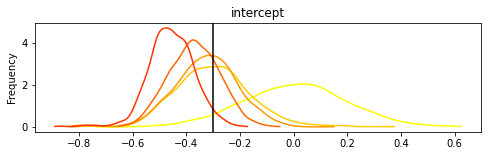

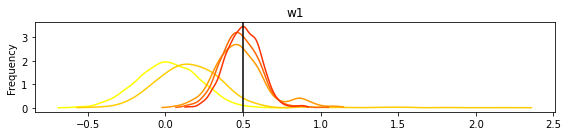

In [7]:
print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
cmap = mpl.cm.autumn
for param in ['intercept', 'w1']:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'intercept': alpha_true, 'w1': beta0_true}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)

plt.tight_layout()

In [8]:
from scipy.stats import multivariate_normal

In [9]:
def plot_posterior(trace, axis):
    prior = np.concatenate([trace.intercept.reshape(1, -1), trace.w1.reshape(1, -1)], axis=0)

    covariance = np.cov(prior) 
    means = np.array([trace.intercept.mean(), trace.w1.mean()])

    x, y = np.mgrid[-1:1:.01, -1:1:.01]
    pos = np.dstack((x, y))

    rv = multivariate_normal(means, covariance)

    axis.contour(rv.pdf(pos).T, cmap='jet')
    axis.set_xticks(np.linspace(0, 200, 3))
    axis.set_xlabel(r'$intercept$')
    axis.set_ylabel(r'$w_1$')
    axis.set_yticks(np.linspace(0, 200, 3))
    

    return axis

In [10]:
def plot_equations(trace, axis):
    x = np.linspace(0, 1, 2)
    for sample in np.random.choice(trace, 5):
        axis.plot(sample['intercept'] + sample['w1'] * x, c='r', alpha=0.30)
        
    axis.plot(alpha_true + beta0_true * x)

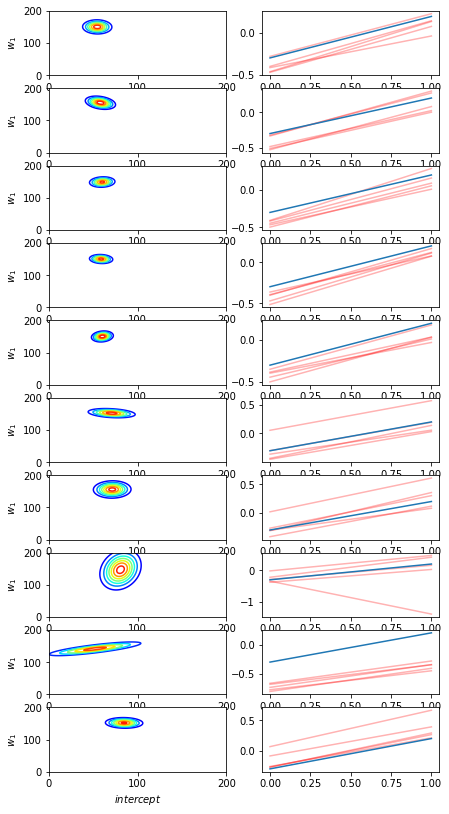

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=10, figsize=(7, 14))

for index, trace in enumerate(traces[:10]):
    plot_posterior(trace, axes[index, 0])
    plot_equations(trace, axes[index, 1])